# Danny's Diner

In [31]:
from IPython.display import Image

# ER Diagram

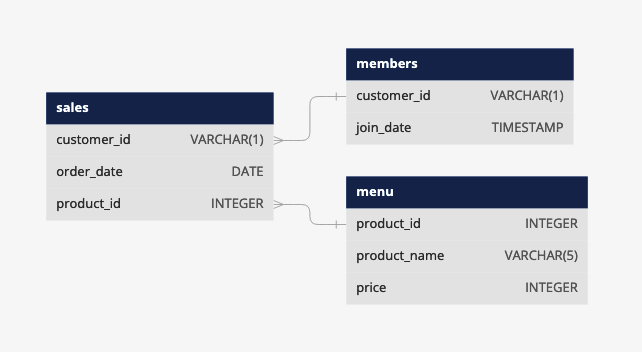

In [53]:
Image(filename="./assets/dannys-diner/dannys-diner-1.png")

# Datasets

## sales

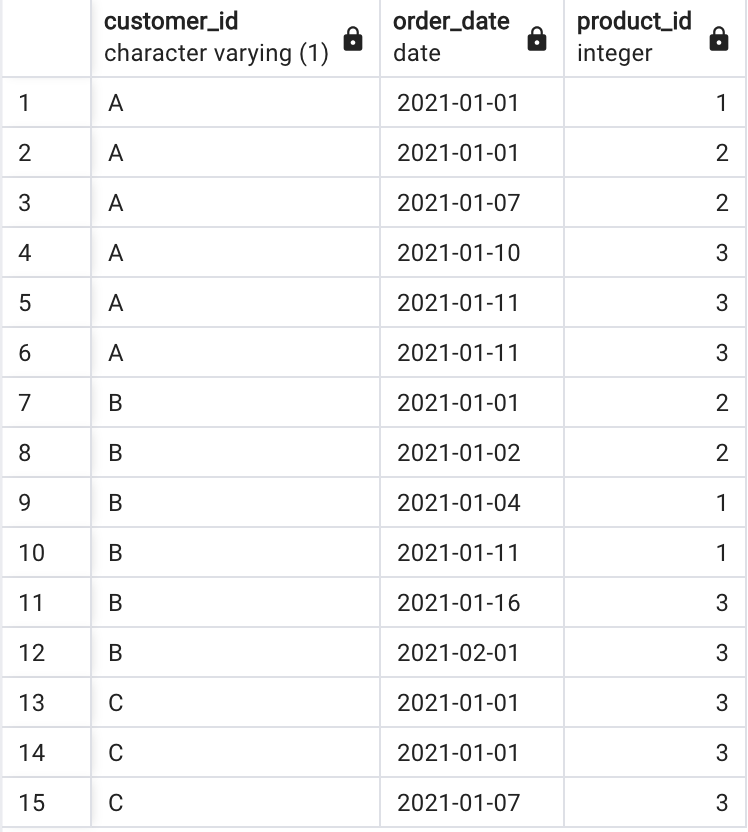

In [54]:
Image(filename="./assets/dannys-diner/dannys-diner-2.png", width=400)

## menu

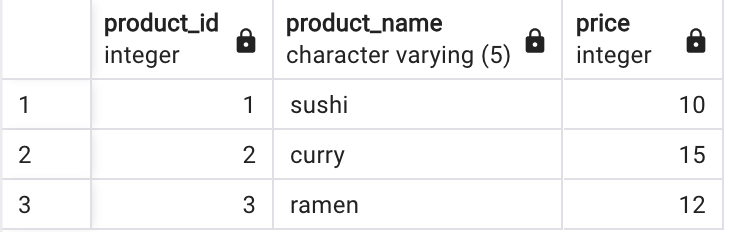

In [55]:
Image(filename="./assets/dannys-diner/dannys-diner-3.png", width=400)

## members

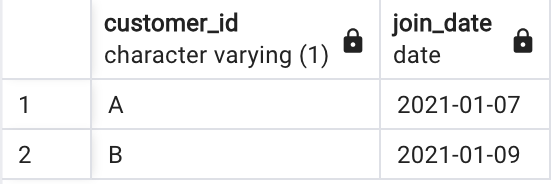

In [56]:
Image(filename="./assets/dannys-diner/dannys-diner-4.png", width=400)

# Questions

***

```1. What is the total amount each customer spent at the restaurant?```

```sql
select 
	sales.customer_id,
	SUM(menu.price) as "total_spent"
from dannys_diner.sales
	inner join dannys_diner.menu on sales.product_id = menu.product_id
group by sales.customer_id
order by "total_spent" desc;
```

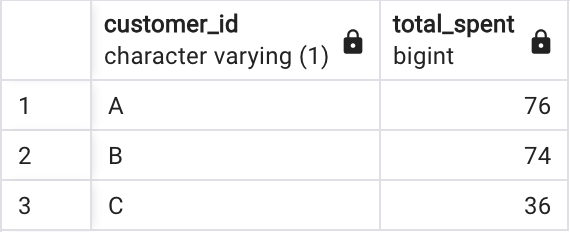

In [57]:
Image(filename="./assets/dannys-diner/dannys-diner-5.png", width=400)

**Observations**: total amount spent by customers A and B are very close while coustomer C's spending is comparatively quiet low.

***

```2. How many days has each customer visited the restaurant?```

```sql
select 
	sales.customer_id,
	COUNT(DISTINCT sales.order_date) as "days_visited"
from dannys_diner.sales
group by sales.customer_id
order by "days_visited" desc;
```

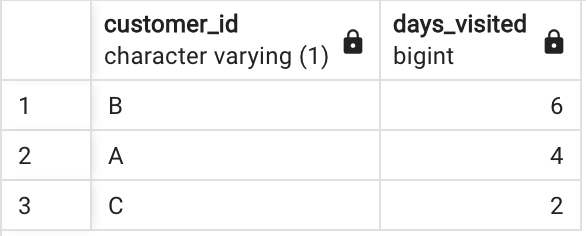

In [58]:
Image(filename="./assets/dannys-diner/dannys-diner-6.png", width=400)

**Observations**: Customer B has visited the most, followed by customer A. Customer C has visited the least and also spent the least.

***

```3. What was the first item from the menu purchased by each customer?```

```sql
with purchase_order as (
	select 
		sales.customer_id,
		sales.order_date,
		sales.product_id,
		menu.product_name,
		rank() over(partition by sales.customer_id order by sales.order_date) as "order_number"
	from dannys_diner.sales
		inner join dannys_diner.menu on sales.product_id = menu.product_id
)
select distinct
	customer_id,
	product_name
from purchase_order
where order_number = 1
order by customer_id;
```

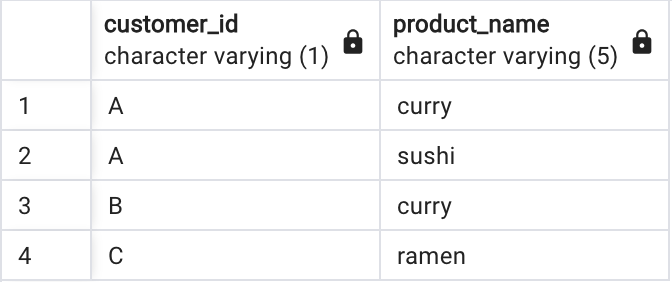

In [59]:
Image(filename="./assets/dannys-diner/dannys-diner-7.png", width=400)

**Observations**<br>
During the first visit: 
- Customer A has ordered ```curry``` and ```sushi```
- Customer B has ordered ```curry```
- Customer C has ordered ```ramen```

***

```4. What is the most purchased item on the menu and how many times was it purchased by all customers?```

```sql
select 
	menu.product_name,
	count(*) as "total_purchases"
from dannys_diner.sales
	inner join dannys_diner.menu on sales.product_id = menu.product_id
group by menu.product_name
order by "total_purchases" desc
limit 1;
```

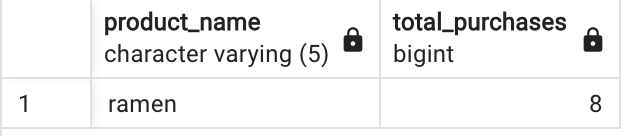

In [60]:
Image(filename="./assets/dannys-diner/dannys-diner-8.png", width=400)

**Observations**: Most purchased item is ```ramen```

***

```5. Which item was the most popular for each customer?```

```sql
with ranked_items as (
	select 
		sales.customer_id,
		max(menu.product_name) as "product_name",
		count(*) as "times_purchased",
		rank() over(partition by sales.customer_id order by count(*) desc) as "item_rank"
	from dannys_diner.sales
		inner join dannys_diner.menu on sales.product_id = menu.product_id
	group by sales.customer_id, sales.product_id
)
select
	customer_id,
	product_name,
	times_purchased
from ranked_items
where item_rank = 1
order by customer_id, product_name;
```

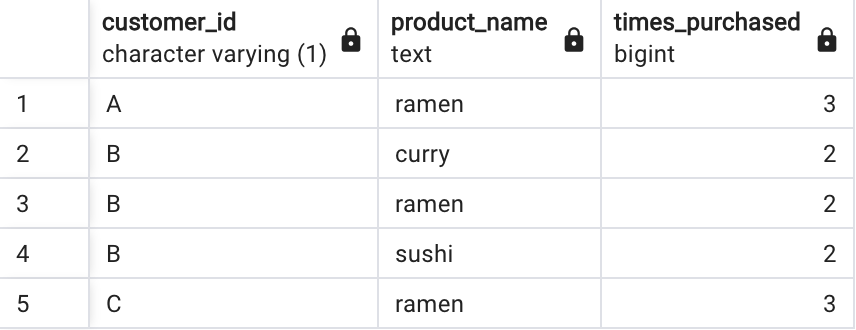

In [61]:
Image(filename="./assets/dannys-diner/dannys-diner-9.png", width=500)

**Observations**: 
- each customer can have more than 1 favourite item
- ```ramen``` is most popular among customer A and C
- Customer B equally likes all 3 items on the menu

***

```6. Which item was purchased first by the customer after they became a member?```

**Note**: Not all customers present in the sales records are members. Customers A and B are members while Customer C is not.

```sql
with ranked_orders_after_join as (
	select
		sales.customer_id,
		menu.product_name,
		sales.order_date,
		rank() over(partition by sales.customer_id order by sales.order_date) as "order_rank"
	from dannys_diner.sales
		inner join dannys_diner.menu on sales.product_id = menu.product_id
	where exists (
		select 1
		from dannys_diner.members
		where members.customer_id = sales.customer_id and sales.order_date >= members.join_date
	)
)

select 
	customer_id,
	product_name,
	order_date
from ranked_orders_after_join
where order_rank = 1
order by customer_id, product_name;
```

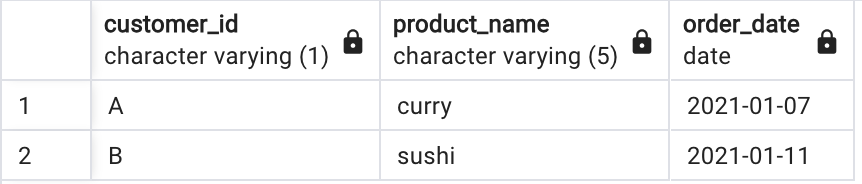

In [62]:
Image(filename="./assets/dannys-diner/dannys-diner-10.png", width=600)

**Observations**: <br>
First item purchased after becoming a member:
- Customer A: ```curry```
- Customer B: ```sushi```

***

```7. Which item was purchased just before the customer became a member?```

```sql
with ranked_orders_before_join as (
	select
		sales.customer_id,
		menu.product_name,
		sales.order_date,
		rank() over(partition by sales.customer_id order by sales.order_date desc) as "order_rank"
	from dannys_diner.sales
		inner join dannys_diner.menu on sales.product_id = menu.product_id
	where exists (
		select 1
		from dannys_diner.members
		where members.customer_id = sales.customer_id and sales.order_date < members.join_date
	)
)

select 
	customer_id,
	product_name,
	order_date
from ranked_orders_before_join
where order_rank = 1
order by customer_id, product_name;
```

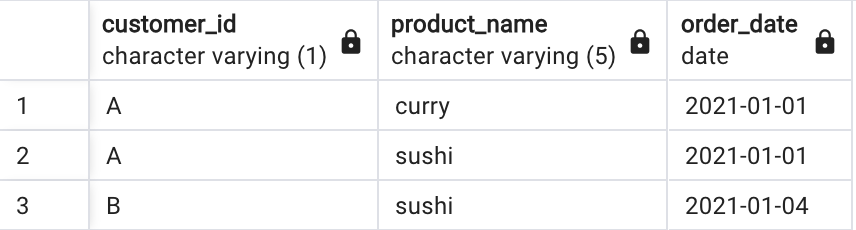

In [63]:
Image(filename="./assets/dannys-diner/dannys-diner-11.png", width=700)

**Observations**: Just before becoming a member, ```Customer A``` purchased ```sushi and curry``` on the same date while ```Customer B``` purchased ```sushi```.

***

```8. What is the total items and amount spent for each member before they became a member?```

```sql
with before_join as (
	select
		sales.customer_id,
		count(distinct sales.product_id) as "unique_menu_items",
		sum(menu.price) as "total_spent"
	from dannys_diner.sales
		inner join dannys_diner.menu on sales.product_id = menu.product_id
	where exists (
		select 1
		from dannys_diner.members
		where members.customer_id = sales.customer_id and sales.order_date < members.join_date
	)
	group by sales.customer_id
)

select 
	*
from before_join;
```

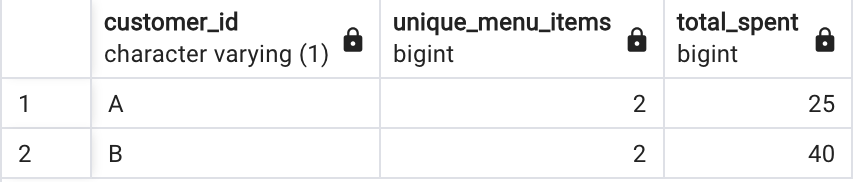

In [64]:
Image(filename="./assets/dannys-diner/dannys-diner-12.png", width=700)

**Observations**:<br>
Before becoming members:
- Customer A: Purchased 2 items, spending \$25 in total
- Customer B: Purchased 3 items, spending \$40 in total

***

```9. If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?```

```sql
select 
	customer_id,
	sum(
		case
			when lower(menu.product_name) like 'sushi' then menu.price*10*2
			else menu.price*10
		end
	) as "points"
from dannys_diner.sales
	inner join dannys_diner.menu on sales.product_id = menu.product_id
group by customer_id
order by points desc;
```

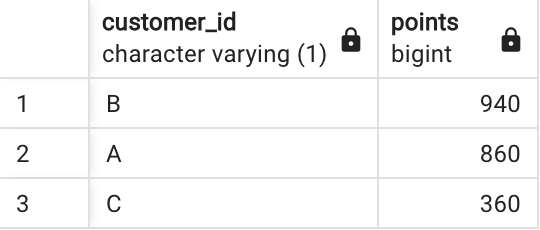

In [65]:
Image(filename="./assets/dannys-diner/dannys-diner-13.png", width=500)

Customer B is the most points followed by Customer A. Customer C has comparatively very low amount of points.

***

```10. In the first week after a customer joins the program (including their join date) they earn 2x points on all items, not just sushi - how many points do customer A and B have at the end of January?```

```sql
select 
	sales.customer_id,
	sum(
		case
			when sales.order_date between members.join_date and members.join_date+6 then menu.price*10*2
			when lower(menu.product_name) like 'sushi' then menu.price*10*2
			else menu.price*10
		end
	) as "points"
from dannys_diner.sales
	inner join dannys_diner.menu on sales.product_id = menu.product_id
	inner join dannys_diner.members on sales.customer_id = members.customer_id
where sales.order_date <= '2021-01-31'::DATE
group by sales.customer_id
order by points desc;
```

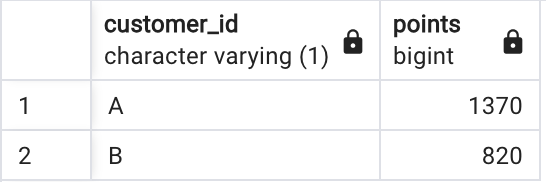

In [66]:
Image(filename="./assets/dannys-diner/dannys-diner-14.png", width=500)

Total Points:
- Customer A: 1370
- Customer B: 820

***

```Additionally Danny needs help to generate some basic datasets so his team can easily inspect the data without needing to use SQL.```

***

```Join All The Things```

```sql
select 
	sales.customer_id,
	sales.order_date,
	menu.product_name,
	menu.price,
	case
		when sales.order_date < members.join_date or members.join_date is null then 'N'
		else 'Y'
	end as "member"
from dannys_diner.sales
	inner join dannys_diner.menu on sales.product_id = menu.product_id
	left join dannys_diner.members on sales.customer_id = members.customer_id
order by sales.customer_id, sales.order_date, menu.product_name;
```

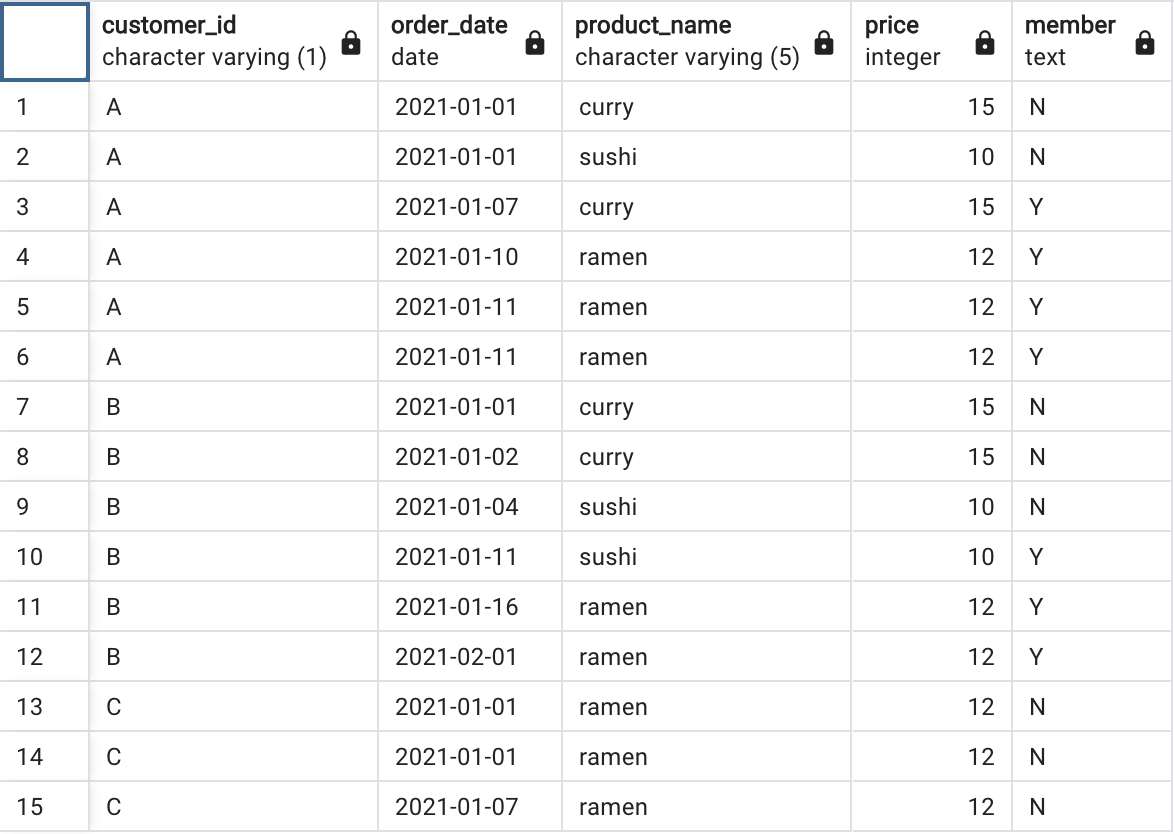

In [67]:
Image(filename="./assets/dannys-diner/dannys-diner-15.png", width=600)

***

```Rank All The Things```

```sql
with cte_1 as (
	select 
		sales.customer_id,
		sales.order_date,
		menu.product_name,
		menu.price,
		case
			when sales.order_date < members.join_date or members.join_date is null then 'N'
			else 'Y'
		end as "member"
	from dannys_diner.sales
		inner join dannys_diner.menu on sales.product_id = menu.product_id
		left join dannys_diner.members on sales.customer_id = members.customer_id
)

select 
	*,
	case
		when lower(member) like 'n' then null
		else dense_rank() over(partition by customer_id, member order by order_date)
	end as "ranking"
from cte_1
order by customer_id, order_date, product_name;
```

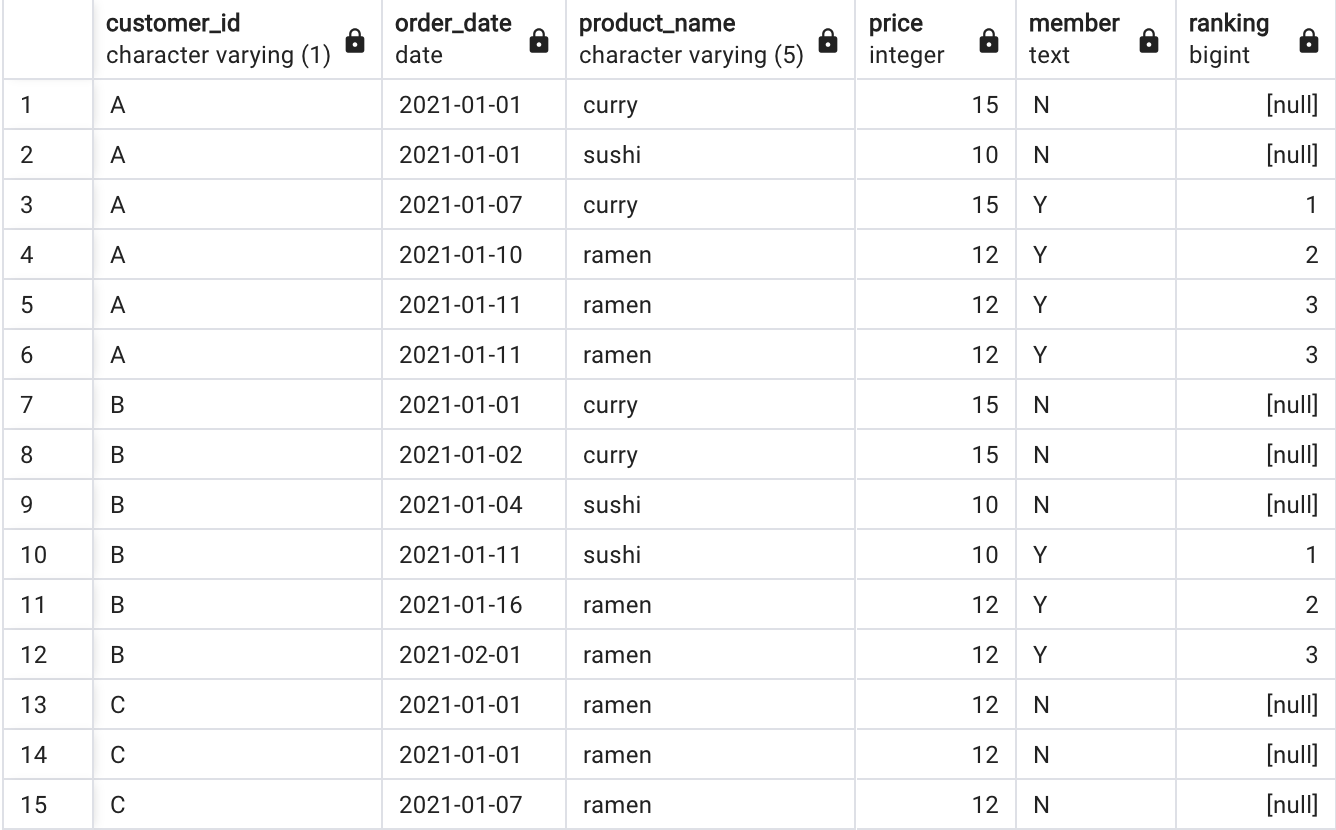

In [68]:
Image(filename="./assets/dannys-diner/dannys-diner-16.png", width=700)